In [1]:
import os
import pandas as pd
import numpy as np

import joblib
import sidetable

from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from itertools import combinations
from MetsDataByGender import get_mets_data
from MetsEvaluation import get_feature_importance, get_metric, get_calib_metric

from numpy import array
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
os.environ['CUDA_VISIBLE_DEVICES'] = f"1"

In [2]:
def get_new_cat_info(slc_fts, X_train, cat_col) :
    new_X_train = X_train[slc_fts]
    idx = new_X_train.columns.isin(cat_col)
    cat_col = new_X_train.columns[idx]
    cat_dims =  {}
    cat_idxs = {}

    for col in cat_col:
        cat_dims[col] = new_X_train.loc[:,col].nunique()
    cat_idxs = [ i for i, f in enumerate(new_X_train) if f in cat_col]
    cat_dims = [ cat_dims[f] for i, f in enumerate(new_X_train) if f in cat_col]
    
    return cat_idxs, cat_dims

In [3]:
def train_model(model, X_train, y_train, X_valid, y_valid) :
    model.fit(
        X_train=X_train.values[:], y_train=y_train.values[:],
        eval_set=[(X_train.values[:], y_train.values[:]), (X_valid.values[:], y_valid.values[:])],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=200, 
        patience=50,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False)
    return model

### Dataset

In [6]:
# fts_ctg : 'anthropometric', 'survey-based', 'synthesized'
# fts : Define features to add as a list
# gender : 0 male, 1 female
add_fts = []
tr, val, ts, info, beta, tau, ctg_idxs, ctg_dims = get_mets_data(fts_ctg='', fts = add_fts, gender=0, ONEHOT=False, TABNET=True, mrmr=False, SEED=100)

### Trial 1 : Base Model 
- Default Parameter

In [9]:
X_train = tr.iloc[:,1:]
y_train = tr.iloc[:,0]
X_valid = val.iloc[:,1:]
y_valid = val.iloc[:,0]

args = {"seed" : 100, 'verbose':0}
estimator = TabNetClassifier(cat_idxs=ctg_idxs, cat_dims=ctg_dims, **args)

base_model = train_model(estimator, X_train, y_train, X_valid, y_valid)

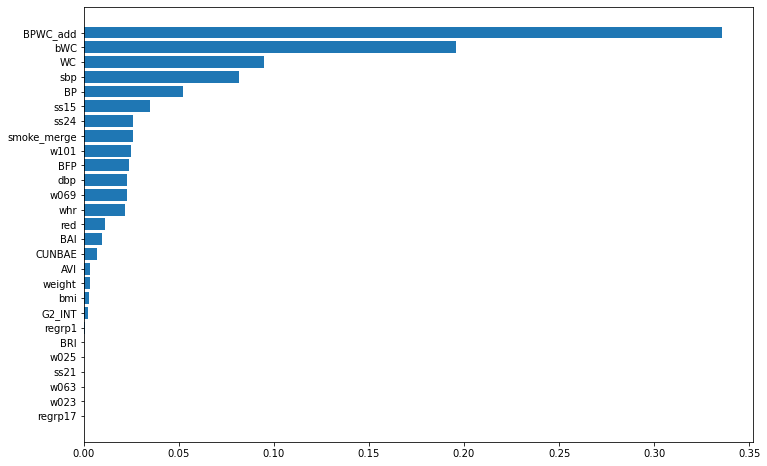

In [256]:
prob = base_model.predict_proba(X_valid.values[:])
get_metric(prob, y_valid, 0.5)

fts = get_feature_importance(base_model.feature_importances_, X_train.columns, 30)
plt.figure(figsize=(12,8))
plt.barh(fts['feature'], fts['importance'])
plt.gca().invert_yaxis()
plt.show()

### Trial 2. Feature Selection Model

### Backward Elimination

In [257]:
slc_fts = []
res = 0

ctg_col = pd.read_csv('./data/col_info.csv')
cat_col = ~(ctg_col.attribute == 'I') & (ctg_col.type == 'C')

if fts.feature.count() > 10 :
    for i in range(fts.feature.count(),9,-1) :
        print('=====',i,'=====')
        top_fts = fts[:i]
        slc_fts = top_fts.feature

        idx = slc_fts.isin(cat_col)
        cat_col = top_fts[idx].feature
        cat_idx, cat_dim = get_new_cat_info(slc_fts, X_train, cat_col)

        estimator = TabNetClassifier(cat_idxs=cat_idx, cat_dims=cat_dim, **args)
        top_n_model = train_model(estimator, X_train[slc_fts], y_train, X_valid[slc_fts], y_valid)

        prob = top_n_model.predict_proba(X_valid[slc_fts].values[:])
        res = get_metric(prob, y_valid, 0.5)

        fts = get_feature_importance(top_n_model.feature_importances_, X_train[slc_fts].columns, i)
        slc_fts = fts.feature.to_list()
        print('AUC :',res['auc'], 'Fts :', slc_fts)


===== 27 =====

Early stopping occurred at epoch 140 with best_epoch = 90 and best_valid_auc = 0.86634
AUC : 0.8663449820493397 Fts : ['BPWC_add', 'BFP', 'AVI', 'sbp', 'BRI', 'bWC', 'bmi', 'smoke_merge', 'WC', 'ss21', 'dbp', 'weight', 'G2_INT', 'ss24', 'CUNBAE', 'w069', 'whr', 'w025', 'BAI', 'w063', 'ss15', 'regrp17', 'w101', 'w023', 'red']
===== 26 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 90 with best_epoch = 40 and best_valid_auc = 0.87096
AUC : 0.8709627482625737 Fts : ['BPWC_add', 'weight', 'bmi', 'WC', 'sbp', 'bWC', 'BFP', 'smoke_merge', 'BAI', 'whr', 'CUNBAE', 'w101', 'w069', 'G2_INT', 'dbp', 'ss15', 'ss21', 'regrp17', 'w025', 'ss24', 'AVI', 'w063', 'BRI']
===== 25 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 117 with best_epoch = 67 and best_valid_auc = 0.86689
AUC : 0.8668867955600934 Fts : ['BPWC_add', 'sbp', 'WC', 'bWC', 'smoke_merge', 'weight', 'AVI', 'BFP', 'dbp', 'BRI', 'ss24', 'bmi', 'whr', 'w069', 'G2_INT', 'CUNBAE', 'w101', 'regrp17', 'BAI', 'ss21', 'w063']
===== 24 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 106 with best_epoch = 56 and best_valid_auc = 0.87114
AUC : 0.8711373143177102 Fts : ['BPWC_add', 'WC', 'sbp', 'bWC', 'bmi', 'BRI', 'CUNBAE', 'ss24', 'ss21', 'w101', 'w063', 'whr', 'G2_INT', 'regrp17', 'BAI', 'BFP', 'dbp', 'smoke_merge', 'w069', 'AVI', 'weight']
===== 23 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 121 with best_epoch = 71 and best_valid_auc = 0.86773
AUC : 0.8677250419946642 Fts : ['BPWC_add', 'weight', 'sbp', 'WC', 'AVI', 'CUNBAE', 'whr', 'smoke_merge', 'BFP', 'bmi', 'ss24', 'w063', 'dbp', 'w101', 'w069', 'BRI', 'regrp17', 'G2_INT', 'BAI', 'bWC']
===== 22 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 170 with best_epoch = 120 and best_valid_auc = 0.87064
AUC : 0.8706383188959521 Fts : ['BPWC_add', 'bWC', 'AVI', 'BFP', 'w069', 'WC', 'BAI', 'sbp', 'dbp', 'weight', 'CUNBAE', 'ss24', 'smoke_merge', 'w063', 'w101', 'BRI', 'whr']
===== 21 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87062
AUC : 0.8706185567010309 Fts : ['BPWC_add', 'bWC', 'WC', 'whr', 'BAI', 'AVI', 'w101', 'ss24', 'BFP', 'sbp', 'w069', 'weight', 'dbp', 'w063', 'BRI', 'CUNBAE']
===== 20 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 153 with best_epoch = 103 and best_valid_auc = 0.87709
AUC : 0.8770890286881197 Fts : ['BPWC_add', 'WC', 'sbp', 'weight', 'bWC', 'whr', 'BFP', 'BRI', 'ss24', 'dbp', 'w069', 'CUNBAE', 'w063', 'w101', 'AVI', 'BAI']
===== 19 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_auc = 0.87512
AUC : 0.875119396594315 Fts : ['BPWC_add', 'WC', 'bWC', 'BRI', 'sbp', 'AVI', 'BFP', 'ss24', 'whr', 'w101', 'w069', 'BAI', 'weight', 'dbp', 'CUNBAE', 'w063']
===== 18 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 180 with best_epoch = 130 and best_valid_auc = 0.87287
AUC : 0.8728689766476729 Fts : ['BPWC_add', 'WC', 'AVI', 'w101', 'CUNBAE', 'dbp', 'bWC', 'whr', 'BFP', 'w069', 'weight', 'BRI', 'BAI', 'ss24', 'sbp']
===== 17 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 131 with best_epoch = 81 and best_valid_auc = 0.87007
AUC : 0.8700685089423932 Fts : ['BPWC_add', 'BRI', 'WC', 'whr', 'sbp', 'CUNBAE', 'AVI', 'ss24', 'w101', 'bWC', 'dbp', 'BAI', 'w069', 'weight', 'BFP']
===== 16 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 116 with best_epoch = 66 and best_valid_auc = 0.87543
AUC : 0.8754290043147459 Fts : ['BPWC_add', 'bWC', 'BAI', 'sbp', 'weight', 'whr', 'WC', 'w101', 'CUNBAE', 'ss24', 'dbp', 'BFP', 'w069', 'BRI']
===== 15 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 114 with best_epoch = 64 and best_valid_auc = 0.87055
AUC : 0.8705535061427491 Fts : ['BPWC_add', 'WC', 'weight', 'whr', 'BRI', 'sbp', 'BFP', 'BAI', 'w101', 'bWC', 'ss24', 'dbp', 'CUNBAE', 'w069']
===== 14 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 119 with best_epoch = 69 and best_valid_auc = 0.8735
AUC : 0.8734988966107835 Fts : ['BPWC_add', 'bWC', 'CUNBAE', 'sbp', 'BRI', 'whr', 'w069', 'weight', 'dbp', 'ss24', 'WC', 'BAI', 'w101', 'BFP']
===== 13 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 111 with best_epoch = 61 and best_valid_auc = 0.87117
AUC : 0.8711653107605151 Fts : ['BPWC_add', 'WC', 'bWC', 'CUNBAE', 'sbp', 'BAI', 'BRI', 'weight', 'w101', 'whr', 'w069', 'dbp', 'ss24']
===== 12 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 99 with best_epoch = 49 and best_valid_auc = 0.8719
AUC : 0.8719030993709035 Fts : ['BPWC_add', 'sbp', 'WC', 'dbp', 'bWC', 'BRI', 'w101', 'CUNBAE', 'weight', 'w069', 'BAI', 'whr']
===== 11 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 194 and best_valid_auc = 0.87376
AUC : 0.8737623925430652 Fts : ['BPWC_add', 'bWC', 'WC', 'BRI', 'CUNBAE', 'weight', 'sbp', 'BAI', 'w101', 'w069', 'dbp']
===== 10 =====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 151 with best_epoch = 101 and best_valid_auc = 0.87357
AUC : 0.8735697111425842 Fts : ['BPWC_add', 'BRI', 'bWC', 'weight', 'sbp', 'w069', 'BAI', 'w101', 'CUNBAE', 'WC']


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### Combination

In [14]:

best_auc = 0
best_res = 0

i = 0
for j in range(6,len(slc_fts)+1) : #len(slc_fts)+1
    i += 1
    print('# Comb :', j, 'no:', i)
    candi = list(combinations(slc_fts, j))
    for i, ft in enumerate(candi):
        ft = list(ft)
        if i % 1000 == 0 :
            print('====',i+1,':',ft,'====')

        cat_idx, cat_dim = get_new_cat_info(ft, X_train, cat_col)

        estimator = TabNetClassifier(cat_idxs=cat_idx, cat_dims=cat_dim, **args)
        model = train_model(estimator, X_train[ft], y_train, X_valid[ft], y_valid)

        prob = model.predict_proba(X_valid[ft].values[:])
        cur = get_metric(prob, y_valid, 0.5)
        
        if cur['auc']> best_auc :
            best_auc = cur['auc']
            best_ft = ft
            best_model = model
            best_res = cur
            print('Best AUC :',best_auc, ' Features : ', best_ft)
    #print('Best AUC :',best_auc, ' Features : ', best_ft)

# Comb : 6 no: 1
==== 1 : ['BPWC_add', 'BRI', 'bWC', 'weight', 'sbp', 'w069'] ====

Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87819
Best AUC : 0.8781924179045486  Features :  ['BPWC_add', 'BRI', 'bWC', 'weight', 'sbp', 'w069']


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87154


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87423


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87729


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.8797
Best AUC : 0.8797025789664372  Features :  ['BPWC_add', 'BRI', 'bWC', 'weight', 'sbp', 'WC']


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 162 with best_epoch = 112 and best_valid_auc = 0.87801


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 144 with best_epoch = 94 and best_valid_auc = 0.87558


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 172 with best_epoch = 122 and best_valid_auc = 0.87498


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.87753


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.8751


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 88 with best_epoch = 38 and best_valid_auc = 0.86702


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87509


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.87187


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.87745


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.87863


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 128 with best_epoch = 78 and best_valid_auc = 0.87522


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 91 with best_epoch = 41 and best_valid_auc = 0.87427


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.8729


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_valid_auc = 0.88086
Best AUC : 0.8808570205197458  Features :  ['BPWC_add', 'BRI', 'bWC', 'sbp', 'w069', 'WC']


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 110 with best_epoch = 60 and best_valid_auc = 0.87345


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 128 with best_epoch = 78 and best_valid_auc = 0.8757


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 174 and best_valid_auc = 0.87942


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87358


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 174 and best_valid_auc = 0.87613


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 141 with best_epoch = 91 and best_valid_auc = 0.87711


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 154 with best_epoch = 104 and best_valid_auc = 0.87398


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 151 and best_valid_auc = 0.87662


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 160 and best_valid_auc = 0.87964


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.87548


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 158 with best_epoch = 108 and best_valid_auc = 0.87553


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.87601


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 113 with best_epoch = 63 and best_valid_auc = 0.87524


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.87672


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.87683


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87346


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 181 and best_valid_auc = 0.87317


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 174 with best_epoch = 124 and best_valid_auc = 0.87202


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.8731


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 134 with best_epoch = 84 and best_valid_auc = 0.87541


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 153 with best_epoch = 103 and best_valid_auc = 0.87058


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 162 and best_valid_auc = 0.87517


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 195 and best_valid_auc = 0.87257


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 143 with best_epoch = 93 and best_valid_auc = 0.87463


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 95 with best_epoch = 45 and best_valid_auc = 0.86896


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_auc = 0.8748


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.86758


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 187 with best_epoch = 137 and best_valid_auc = 0.8696


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_auc = 0.87466


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 108 with best_epoch = 58 and best_valid_auc = 0.87142


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 198 with best_epoch = 148 and best_valid_auc = 0.87566


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.87718


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 172 with best_epoch = 122 and best_valid_auc = 0.87048


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 116 with best_epoch = 66 and best_valid_auc = 0.87398


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 92 with best_epoch = 42 and best_valid_auc = 0.87113


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 90 with best_epoch = 40 and best_valid_auc = 0.87034


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 187 with best_epoch = 137 and best_valid_auc = 0.87223


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 180 with best_epoch = 130 and best_valid_auc = 0.87233


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 119 with best_epoch = 69 and best_valid_auc = 0.87413


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 160 with best_epoch = 110 and best_valid_auc = 0.86992


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 172 with best_epoch = 122 and best_valid_auc = 0.87546


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 98 with best_epoch = 48 and best_valid_auc = 0.87168


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 186 with best_epoch = 136 and best_valid_auc = 0.87277


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 165 with best_epoch = 115 and best_valid_auc = 0.87283


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 138 with best_epoch = 88 and best_valid_auc = 0.87317


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 126 with best_epoch = 76 and best_valid_auc = 0.87709


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 186 with best_epoch = 136 and best_valid_auc = 0.8671


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 140 with best_epoch = 90 and best_valid_auc = 0.87243


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 62 with best_epoch = 12 and best_valid_auc = 0.85462


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.87517


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 145 with best_epoch = 95 and best_valid_auc = 0.87368


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 157 with best_epoch = 107 and best_valid_auc = 0.87944


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 141 with best_epoch = 91 and best_valid_auc = 0.87603


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 125 with best_epoch = 75 and best_valid_auc = 0.87679


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 154 with best_epoch = 104 and best_valid_auc = 0.87962


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 180 with best_epoch = 130 and best_valid_auc = 0.8767


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 141 with best_epoch = 91 and best_valid_auc = 0.87845


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87979


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 164 and best_valid_auc = 0.87421


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 172 with best_epoch = 122 and best_valid_auc = 0.87673


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 111 with best_epoch = 61 and best_valid_auc = 0.87938


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 187 with best_epoch = 137 and best_valid_auc = 0.87697


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 195 with best_epoch = 145 and best_valid_auc = 0.87759


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 176 and best_valid_auc = 0.87776


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 154 and best_valid_auc = 0.87323


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 156 with best_epoch = 106 and best_valid_auc = 0.87484


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.87673


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 102 with best_epoch = 52 and best_valid_auc = 0.87207


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 154 with best_epoch = 104 and best_valid_auc = 0.87395


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 119 with best_epoch = 69 and best_valid_auc = 0.87608


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 193 with best_epoch = 143 and best_valid_auc = 0.87541


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 168 and best_valid_auc = 0.87862


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 161 with best_epoch = 111 and best_valid_auc = 0.874


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 195 with best_epoch = 145 and best_valid_auc = 0.87436


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_auc = 0.87512


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 158 with best_epoch = 108 and best_valid_auc = 0.87662


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 122 with best_epoch = 72 and best_valid_auc = 0.87406


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 175 with best_epoch = 125 and best_valid_auc = 0.87236


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 133 with best_epoch = 83 and best_valid_auc = 0.87411


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 169 and best_valid_auc = 0.87979


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 138 with best_epoch = 88 and best_valid_auc = 0.87571


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 187 with best_epoch = 137 and best_valid_auc = 0.87381


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87561


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87677


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 113 with best_epoch = 63 and best_valid_auc = 0.87583


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 159 and best_valid_auc = 0.8741


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 160 and best_valid_auc = 0.86688


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 176 and best_valid_auc = 0.87137


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 153 with best_epoch = 103 and best_valid_auc = 0.87254


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 195 and best_valid_auc = 0.86722


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87136


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 108 with best_epoch = 58 and best_valid_auc = 0.87257


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.86528


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 181 with best_epoch = 131 and best_valid_auc = 0.87583


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 23 and best_valid_auc = 0.86621


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 136 with best_epoch = 86 and best_valid_auc = 0.87559


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.86402


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.8773


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 164 with best_epoch = 114 and best_valid_auc = 0.87218


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 82 with best_epoch = 32 and best_valid_auc = 0.87058


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 74 with best_epoch = 24 and best_valid_auc = 0.86984


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 134 with best_epoch = 84 and best_valid_auc = 0.86752


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 183 and best_valid_auc = 0.87402


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87335


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 174 with best_epoch = 124 and best_valid_auc = 0.87207


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 117 with best_epoch = 67 and best_valid_auc = 0.87433


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 151 and best_valid_auc = 0.8698


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 170 and best_valid_auc = 0.87139


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 121 with best_epoch = 71 and best_valid_auc = 0.87015


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 126 with best_epoch = 76 and best_valid_auc = 0.8709


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.87249


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 174 with best_epoch = 124 and best_valid_auc = 0.86871


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.87043


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 129 with best_epoch = 79 and best_valid_auc = 0.86907


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 172 with best_epoch = 122 and best_valid_auc = 0.86872


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87027


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 138 with best_epoch = 88 and best_valid_auc = 0.86722


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 160 with best_epoch = 110 and best_valid_auc = 0.82371


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 108 with best_epoch = 58 and best_valid_auc = 0.82953


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 8 and best_valid_auc = 0.80975


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 91 with best_epoch = 41 and best_valid_auc = 0.82316


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 168 and best_valid_auc = 0.82235


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 151 with best_epoch = 101 and best_valid_auc = 0.82572


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.82051


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 9 and best_valid_auc = 0.81312


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 170 with best_epoch = 120 and best_valid_auc = 0.82786


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 110 with best_epoch = 60 and best_valid_auc = 0.82478


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 115 with best_epoch = 65 and best_valid_auc = 0.87005


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 180 with best_epoch = 130 and best_valid_auc = 0.86943


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 150 with best_epoch = 100 and best_valid_auc = 0.86574


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 169 with best_epoch = 119 and best_valid_auc = 0.86783


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.86883


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 165 with best_epoch = 115 and best_valid_auc = 0.8687


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 165 and best_valid_auc = 0.8691


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 170 with best_epoch = 120 and best_valid_auc = 0.86939


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 187 with best_epoch = 137 and best_valid_auc = 0.86999


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 126 with best_epoch = 76 and best_valid_auc = 0.86609


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 126 with best_epoch = 76 and best_valid_auc = 0.82586


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 101 with best_epoch = 51 and best_valid_auc = 0.81703


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 169 and best_valid_auc = 0.8276


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 92 with best_epoch = 42 and best_valid_auc = 0.82572


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 129 with best_epoch = 79 and best_valid_auc = 0.82087


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 104 with best_epoch = 54 and best_valid_auc = 0.86013


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 172 with best_epoch = 122 and best_valid_auc = 0.86234


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 174 with best_epoch = 124 and best_valid_auc = 0.86834


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 150 with best_epoch = 100 and best_valid_auc = 0.8646


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.86961


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 195 and best_valid_auc = 0.86774


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 188 with best_epoch = 138 and best_valid_auc = 0.86216


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 149 with best_epoch = 99 and best_valid_auc = 0.86689


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 166 with best_epoch = 116 and best_valid_auc = 0.86316


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_auc = 0.86654


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 190 with best_epoch = 140 and best_valid_auc = 0.82066


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 174 with best_epoch = 124 and best_valid_auc = 0.82515


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_valid_auc = 0.82801


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.82432


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 141 with best_epoch = 91 and best_valid_auc = 0.82363


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 150 and best_valid_auc = 0.85467


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 180 with best_epoch = 130 and best_valid_auc = 0.8675


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 130 with best_epoch = 80 and best_valid_auc = 0.86993


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 182 with best_epoch = 132 and best_valid_auc = 0.86905


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 176 and best_valid_auc = 0.86922


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 158 with best_epoch = 108 and best_valid_auc = 0.82324


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.86828


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 170 and best_valid_auc = 0.86894


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 125 with best_epoch = 75 and best_valid_auc = 0.87123


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 145 with best_epoch = 95 and best_valid_auc = 0.86958


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 114 with best_epoch = 64 and best_valid_auc = 0.86936


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 150 and best_valid_auc = 0.86766


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 135 with best_epoch = 85 and best_valid_auc = 0.87009


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 167 and best_valid_auc = 0.86985


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 133 with best_epoch = 83 and best_valid_auc = 0.86788


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.8658


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.82895


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 148 with best_epoch = 98 and best_valid_auc = 0.82225


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.82457


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 127 with best_epoch = 77 and best_valid_auc = 0.82185


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.82289


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 131 with best_epoch = 81 and best_valid_auc = 0.86876


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 180 with best_epoch = 130 and best_valid_auc = 0.86901


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87321


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 110 with best_epoch = 60 and best_valid_auc = 0.86571


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 137 with best_epoch = 87 and best_valid_auc = 0.86988


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 129 with best_epoch = 79 and best_valid_auc = 0.82443


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 198 and best_valid_auc = 0.83998


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.86763


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 138 with best_epoch = 88 and best_valid_auc = 0.86725


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 168 and best_valid_auc = 0.86802


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 110 with best_epoch = 60 and best_valid_auc = 0.86619


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 157 and best_valid_auc = 0.82339


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 162 with best_epoch = 112 and best_valid_auc = 0.87092
# Comb : 7 no: 210
==== 1 : ['BPWC_add', 'BRI', 'bWC', 'weight', 'sbp', 'w069', 'BAI'] ====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 89 with best_epoch = 39 and best_valid_auc = 0.87224


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 104 with best_epoch = 54 and best_valid_auc = 0.87534


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 126 with best_epoch = 76 and best_valid_auc = 0.87797


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 98 with best_epoch = 48 and best_valid_auc = 0.87462


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 169 and best_valid_auc = 0.87531


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 164 and best_valid_auc = 0.88045


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_auc = 0.87594


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87568


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 164 and best_valid_auc = 0.87779


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.87689


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 157 with best_epoch = 107 and best_valid_auc = 0.8723


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 191 with best_epoch = 141 and best_valid_auc = 0.87849


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 181 with best_epoch = 131 and best_valid_auc = 0.87914


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 102 with best_epoch = 52 and best_valid_auc = 0.87259


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 176 and best_valid_auc = 0.87438


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 114 with best_epoch = 64 and best_valid_auc = 0.87728


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87596


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 78 with best_epoch = 28 and best_valid_auc = 0.87358


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.87329


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 116 with best_epoch = 66 and best_valid_auc = 0.87277


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.87473


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 151 and best_valid_auc = 0.87774


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 176 with best_epoch = 126 and best_valid_auc = 0.87926


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 125 with best_epoch = 75 and best_valid_auc = 0.8695


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.8758


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87697


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 151 with best_epoch = 101 and best_valid_auc = 0.87909


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 101 with best_epoch = 51 and best_valid_auc = 0.87218


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 151 and best_valid_auc = 0.87888


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 84 with best_epoch = 34 and best_valid_auc = 0.86909


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 190 with best_epoch = 140 and best_valid_auc = 0.88024


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 112 with best_epoch = 62 and best_valid_auc = 0.87853


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 151 and best_valid_auc = 0.87668


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 162 with best_epoch = 112 and best_valid_auc = 0.87429


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.87374


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 181 with best_epoch = 131 and best_valid_auc = 0.86952


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87083


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 194 with best_epoch = 144 and best_valid_auc = 0.88136
Best AUC : 0.8813560159415038  Features :  ['BPWC_add', 'BRI', 'weight', 'sbp', 'w069', 'BAI', 'WC']


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 91 with best_epoch = 41 and best_valid_auc = 0.86827


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 160 with best_epoch = 110 and best_valid_auc = 0.87149


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87424


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 162 and best_valid_auc = 0.87304


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 112 with best_epoch = 62 and best_valid_auc = 0.87228


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 143 with best_epoch = 93 and best_valid_auc = 0.87259


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 143 with best_epoch = 93 and best_valid_auc = 0.86837


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 138 with best_epoch = 88 and best_valid_auc = 0.87172


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87755


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 83 with best_epoch = 33 and best_valid_auc = 0.86775


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 112 with best_epoch = 62 and best_valid_auc = 0.86973


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 143 with best_epoch = 93 and best_valid_auc = 0.87202


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 68 with best_epoch = 18 and best_valid_auc = 0.85033


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 161 with best_epoch = 111 and best_valid_auc = 0.87233


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 156 with best_epoch = 106 and best_valid_auc = 0.87707


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 125 with best_epoch = 75 and best_valid_auc = 0.87584


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 144 with best_epoch = 94 and best_valid_auc = 0.87238


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 97 with best_epoch = 47 and best_valid_auc = 0.86791


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 196 with best_epoch = 146 and best_valid_auc = 0.87483


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 160 and best_valid_auc = 0.87752


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 188 with best_epoch = 138 and best_valid_auc = 0.87608


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.87399


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 172 with best_epoch = 122 and best_valid_auc = 0.87372


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 159 with best_epoch = 109 and best_valid_auc = 0.86937


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 141 with best_epoch = 91 and best_valid_auc = 0.87135


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_auc = 0.8727


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87553


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 127 with best_epoch = 77 and best_valid_auc = 0.87123


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 113 with best_epoch = 63 and best_valid_auc = 0.87264


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 125 with best_epoch = 75 and best_valid_auc = 0.87145


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87178


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.87372


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 174 with best_epoch = 124 and best_valid_auc = 0.86831


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 129 with best_epoch = 79 and best_valid_auc = 0.8734


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87759


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87733


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87631


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 142 with best_epoch = 92 and best_valid_auc = 0.87448


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 143 with best_epoch = 93 and best_valid_auc = 0.87762


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 167 with best_epoch = 117 and best_valid_auc = 0.86691


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 131 with best_epoch = 81 and best_valid_auc = 0.87227


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 140 with best_epoch = 90 and best_valid_auc = 0.87076


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 188 with best_epoch = 138 and best_valid_auc = 0.87696


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 124 with best_epoch = 74 and best_valid_auc = 0.87268


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 157 with best_epoch = 107 and best_valid_auc = 0.8719


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 169 and best_valid_auc = 0.87347


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 179 with best_epoch = 129 and best_valid_auc = 0.86872


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 127 with best_epoch = 77 and best_valid_auc = 0.86764


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 194 with best_epoch = 144 and best_valid_auc = 0.87079


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 141 with best_epoch = 91 and best_valid_auc = 0.86405


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 182 with best_epoch = 132 and best_valid_auc = 0.8692


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 182 with best_epoch = 132 and best_valid_auc = 0.86665


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.86664


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 118 with best_epoch = 68 and best_valid_auc = 0.86906


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 114 with best_epoch = 64 and best_valid_auc = 0.86829


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 189 with best_epoch = 139 and best_valid_auc = 0.86722


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 185 with best_epoch = 135 and best_valid_auc = 0.82443


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 89 with best_epoch = 39 and best_valid_auc = 0.82043


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 151 with best_epoch = 101 and best_valid_auc = 0.82437


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 116 with best_epoch = 66 and best_valid_auc = 0.81981


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 61 with best_epoch = 11 and best_valid_auc = 0.80837


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 199 with best_epoch = 149 and best_valid_auc = 0.86964


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 178 with best_epoch = 128 and best_valid_auc = 0.87197


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 153 with best_epoch = 103 and best_valid_auc = 0.87057


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 124 with best_epoch = 74 and best_valid_auc = 0.86651


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 164 with best_epoch = 114 and best_valid_auc = 0.86873


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 172 with best_epoch = 122 and best_valid_auc = 0.82072


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.86407


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 158 with best_epoch = 108 and best_valid_auc = 0.871


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 154 and best_valid_auc = 0.86783


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 127 with best_epoch = 77 and best_valid_auc = 0.8665


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 180 with best_epoch = 130 and best_valid_auc = 0.86808


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.82447


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.86785


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 140 with best_epoch = 90 and best_valid_auc = 0.86752


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 180 with best_epoch = 130 and best_valid_auc = 0.86769


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 157 and best_valid_auc = 0.87157


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 140 with best_epoch = 90 and best_valid_auc = 0.87037


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 191 with best_epoch = 141 and best_valid_auc = 0.87269


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 157 with best_epoch = 107 and best_valid_auc = 0.82186


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.8717


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 169 and best_valid_auc = 0.86533
# Comb : 8 no: 120
==== 1 : ['BPWC_add', 'BRI', 'bWC', 'weight', 'sbp', 'w069', 'BAI', 'w101'] ====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 163 with best_epoch = 113 and best_valid_auc = 0.87469


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 199 with best_epoch = 149 and best_valid_auc = 0.87711


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 171 and best_valid_auc = 0.87443


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 125 with best_epoch = 75 and best_valid_auc = 0.8768


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.87682


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87285


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_auc = 0.87943


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 140 with best_epoch = 90 and best_valid_auc = 0.8751


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.87463


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 121 with best_epoch = 71 and best_valid_auc = 0.87706


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87258


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 118 with best_epoch = 68 and best_valid_auc = 0.87321


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 198 with best_epoch = 148 and best_valid_auc = 0.87724


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 134 with best_epoch = 84 and best_valid_auc = 0.87559


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 118 with best_epoch = 68 and best_valid_auc = 0.87368


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87336


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 167 and best_valid_auc = 0.88


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 124 with best_epoch = 74 and best_valid_auc = 0.87361


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 110 with best_epoch = 60 and best_valid_auc = 0.87286


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 106 with best_epoch = 56 and best_valid_auc = 0.87137


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 194 and best_valid_auc = 0.87577


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 193 with best_epoch = 143 and best_valid_auc = 0.8735


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 194 with best_epoch = 144 and best_valid_auc = 0.87851


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 153 with best_epoch = 103 and best_valid_auc = 0.87393


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 140 with best_epoch = 90 and best_valid_auc = 0.876


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 79 with best_epoch = 29 and best_valid_auc = 0.86853


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 150 with best_epoch = 100 and best_valid_auc = 0.87286


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 193 with best_epoch = 143 and best_valid_auc = 0.87344


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 109 with best_epoch = 59 and best_valid_auc = 0.87429


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87914


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 189 with best_epoch = 139 and best_valid_auc = 0.87868


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 164 and best_valid_auc = 0.87629


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87852


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 169 and best_valid_auc = 0.87627


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 112 with best_epoch = 62 and best_valid_auc = 0.87273


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 129 with best_epoch = 79 and best_valid_auc = 0.87325


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 191 with best_epoch = 141 and best_valid_auc = 0.87032


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_auc = 0.86731


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 154 with best_epoch = 104 and best_valid_auc = 0.87142


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 129 with best_epoch = 79 and best_valid_auc = 0.8704


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.86851


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 144 with best_epoch = 94 and best_valid_auc = 0.82601


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 195 with best_epoch = 145 and best_valid_auc = 0.86996


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_auc = 0.86921


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 151 and best_valid_auc = 0.86959
# Comb : 9 no: 45
==== 1 : ['BPWC_add', 'BRI', 'bWC', 'weight', 'sbp', 'w069', 'BAI', 'w101', 'CUNBAE'] ====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 164 with best_epoch = 114 and best_valid_auc = 0.87465


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 161 with best_epoch = 111 and best_valid_auc = 0.87343


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 96 with best_epoch = 46 and best_valid_auc = 0.87126


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 89 with best_epoch = 39 and best_valid_auc = 0.86799


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 169 and best_valid_auc = 0.87703


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 147 with best_epoch = 97 and best_valid_auc = 0.87294


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 141 with best_epoch = 91 and best_valid_auc = 0.87124


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 145 with best_epoch = 95 and best_valid_auc = 0.87532


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 172 and best_valid_auc = 0.8724


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 189 with best_epoch = 139 and best_valid_auc = 0.87085
# Comb : 10 no: 10
==== 1 : ['BPWC_add', 'BRI', 'bWC', 'weight', 'sbp', 'w069', 'BAI', 'w101', 'CUNBAE', 'WC'] ====


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 113 with best_epoch = 63 and best_valid_auc = 0.87411


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [15]:
print('Best AUC :',best_auc, ' Features : ', best_ft)

Best AUC : 0.8813560159415038  Features :  ['BPWC_add', 'BRI', 'weight', 'sbp', 'w069', 'BAI', 'WC']


----

### Model Tuning

In [16]:
# fts_ctg : 'anthropometric', 'survey-based', 'synthesized'
# fts : Define features to add as a list
# gender : 0 male, 1 female
tr, val, ts, info, beta, tau, ctg_idxs, ctg_dims = get_mets_data(fts_ctg='', fts = best_ft, gender=None, ONEHOT=False, TABNET=True, mrmr=False, SEED=100)

In [17]:
param_grid ={
    'n_steps': [2,3],
    'gamma': [0.7, 1, 1.3],
    'n_independent': [2,3], 
    'n_shared': [2,3], 
    'momentum' : [0.01,0.03],
    'seed' : [100]
}

In [18]:
from sklearn.model_selection import ParameterGrid

In [19]:
best_ft = slc_fts
cat_col = ~(ctg_col.attribute == 'I') & (ctg_col.type == 'C')

params = list(ParameterGrid(param_grid))

opt_param = []
best_auc = 0
best_model = base_model
best_res = []

cat_idxs, cat_dims = get_new_cat_info(best_ft, X_train, cat_col)

for i, args in enumerate(params) :
    print(i+1,'/',len(params), args)
    estimator = TabNetClassifier(cat_idxs=cat_idxs, cat_dims=cat_dims, **args, verbose = 0)
    candi_model = train_model(estimator, X_train.loc[:,best_ft], y_train, X_valid.loc[:,best_ft], y_valid)
    
    prob = candi_model.predict_proba(X_valid.loc[:,best_ft].values[:])
    cur = get_metric(prob, y_valid, 0.5)
    
    print('Current AUC :', cur['auc'])

    if cur['auc'] > best_auc :
        best_auc = cur['auc']
        opt_param = args
        best_res = cur
        best_model = candi_model
    
    print('Best AUC :',best_auc, 'Best_Fts :', opt_param)

1 / 48 {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 2, 'seed': 100}

Early stopping occurred at epoch 188 with best_epoch = 138 and best_valid_auc = 0.87204
Current AUC : 0.8720397878857745
Best AUC : 0.8720397878857745 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 2, 'seed': 100}
2 / 48 {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 150 and best_valid_auc = 0.87959
Current AUC : 0.879587299496064
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
3 / 48 {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87753
Current AUC : 0.8775262672507494
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
4 / 48 {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87807
Current AUC : 0.8780672573367148
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
5 / 48 {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 167 and best_valid_auc = 0.87274
Current AUC : 0.8727413458054741
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
6 / 48 {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 130 with best_epoch = 80 and best_valid_auc = 0.87459
Current AUC : 0.8745849939066567
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
7 / 48 {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.87703
Current AUC : 0.8770305655281446
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
8 / 48 {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.87251
Current AUC : 0.8725058463159974
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
9 / 48 {'gamma': 0.7, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 150 and best_valid_auc = 0.87201
Current AUC : 0.8720134382925463
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
10 / 48 {'gamma': 0.7, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 166 with best_epoch = 116 and best_valid_auc = 0.87911
Current AUC : 0.8791113599683805
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
11 / 48 {'gamma': 0.7, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87742
Current AUC : 0.8774249860017787
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
12 / 48 {'gamma': 0.7, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87728
Current AUC : 0.8772817100886006
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
13 / 48 {'gamma': 0.7, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 191 with best_epoch = 141 and best_valid_auc = 0.87309
Current AUC : 0.8730896544909588
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
14 / 48 {'gamma': 0.7, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 160 with best_epoch = 110 and best_valid_auc = 0.87445
Current AUC : 0.8744507756661506
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
15 / 48 {'gamma': 0.7, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.8774
Current AUC : 0.877404400382069
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
16 / 48 {'gamma': 0.7, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 143 with best_epoch = 93 and best_valid_auc = 0.87331
Current AUC : 0.8733095089094562
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
17 / 48 {'gamma': 1, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 111 with best_epoch = 61 and best_valid_auc = 0.87637
Current AUC : 0.8763710022726524
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
18 / 48 {'gamma': 1, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.87573
Current AUC : 0.8757320246368697
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
19 / 48 {'gamma': 1, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 157 with best_epoch = 107 and best_valid_auc = 0.87612
Current AUC : 0.876116564013043
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
20 / 48 {'gamma': 1, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.87948
Current AUC : 0.8794802542735746
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
21 / 48 {'gamma': 1, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 148 with best_epoch = 98 and best_valid_auc = 0.87798
Current AUC : 0.8779840914330884
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
22 / 48 {'gamma': 1, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 134 with best_epoch = 84 and best_valid_auc = 0.87555
Current AUC : 0.8755475774842725
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
23 / 48 {'gamma': 1, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 195 with best_epoch = 145 and best_valid_auc = 0.87463
Current AUC : 0.8746269885708641
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
24 / 48 {'gamma': 1, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 124 with best_epoch = 74 and best_valid_auc = 0.87737
Current AUC : 0.8773656994170153
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
25 / 48 {'gamma': 1, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 111 with best_epoch = 61 and best_valid_auc = 0.876
Current AUC : 0.8759971674187279
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
26 / 48 {'gamma': 1, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 172 with best_epoch = 122 and best_valid_auc = 0.87649
Current AUC : 0.8764879285926023
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
27 / 48 {'gamma': 1, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87633
Current AUC : 0.87632653733408
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
28 / 48 {'gamma': 1, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 171 with best_epoch = 121 and best_valid_auc = 0.87916
Current AUC : 0.8791657060044136
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
29 / 48 {'gamma': 1, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 148 with best_epoch = 98 and best_valid_auc = 0.87805
Current AUC : 0.8780466717170055
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
30 / 48 {'gamma': 1, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 133 with best_epoch = 83 and best_valid_auc = 0.87544
Current AUC : 0.8754388854122064
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
31 / 48 {'gamma': 1, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 110 with best_epoch = 60 and best_valid_auc = 0.87227
Current AUC : 0.8722736405256744
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
32 / 48 {'gamma': 1, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 124 with best_epoch = 74 and best_valid_auc = 0.87782
Current AUC : 0.877818583050624
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
33 / 48 {'gamma': 1.3, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 177 with best_epoch = 127 and best_valid_auc = 0.87528
Current AUC : 0.8752840815519911
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
34 / 48 {'gamma': 1.3, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 113 with best_epoch = 63 and best_valid_auc = 0.87424
Current AUC : 0.8742424491946904
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
35 / 48 {'gamma': 1.3, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 164 with best_epoch = 114 and best_valid_auc = 0.87357
Current AUC : 0.8735680642930075
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
36 / 48 {'gamma': 1.3, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 151 with best_epoch = 101 and best_valid_auc = 0.87545
Current AUC : 0.8754471196600903
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
37 / 48 {'gamma': 1.3, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87431
Current AUC : 0.8743099700273378
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
38 / 48 {'gamma': 1.3, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 89 and best_valid_auc = 0.87547
Current AUC : 0.8754734692533183
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
39 / 48 {'gamma': 1.3, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 163 with best_epoch = 113 and best_valid_auc = 0.8739
Current AUC : 0.8739040216066666
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
40 / 48 {'gamma': 1.3, 'momentum': 0.01, 'n_independent': 3, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 177 and best_valid_auc = 0.87674
Current AUC : 0.8767448371265769
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
41 / 48 {'gamma': 1.3, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 200 with best_epoch = 189 and best_valid_auc = 0.87576
Current AUC : 0.8757591976548862
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
42 / 48 {'gamma': 1.3, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 119 with best_epoch = 69 and best_valid_auc = 0.87448
Current AUC : 0.8744771252593787
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
43 / 48 {'gamma': 1.3, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 173 with best_epoch = 123 and best_valid_auc = 0.87354
Current AUC : 0.8735417146997795
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
44 / 48 {'gamma': 1.3, 'momentum': 0.03, 'n_independent': 2, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87657
Current AUC : 0.8765702710714405
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
45 / 48 {'gamma': 1.3, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 2, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 152 with best_epoch = 102 and best_valid_auc = 0.87418
Current AUC : 0.8741757517868318
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
46 / 48 {'gamma': 1.3, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 164 with best_epoch = 114 and best_valid_auc = 0.87583
Current AUC : 0.8758291887618984
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
47 / 48 {'gamma': 1.3, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 3, 'n_steps': 2, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 163 with best_epoch = 113 and best_valid_auc = 0.87306
Current AUC : 0.8730567174994236
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}
48 / 48 {'gamma': 1.3, 'momentum': 0.03, 'n_independent': 3, 'n_shared': 3, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 154 with best_epoch = 104 and best_valid_auc = 0.87354
Current AUC : 0.8735417146997791
Best AUC : 0.879587299496064 Best_Fts : {'gamma': 0.7, 'momentum': 0.01, 'n_independent': 2, 'n_shared': 2, 'n_steps': 3, 'seed': 100}


/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [20]:
prob = best_model.predict_proba(X_valid.loc[:,best_ft].values[:])
get_metric(prob, y_valid, 0.5)

{'acc': 0.7153097798259088,
 'bac': 0.7923199169987813,
 'recall': 0.9201030927835051,
 'ppv': 0.40476190476190477,
 'npv': 0.9710550887021475,
 'sepecificity': 0.6645367412140575,
 'f1': 0.5622047244094488,
 'auc': 0.879587299496064}

In [23]:
get_feature_importance(best_model.feature_importances_, X_train.loc[:,best_ft].columns, 30)

,feature,importance
0,BPWC_add,0.344321
9,WC,0.210662
1,BRI,0.118608
6,BAI,0.106061
4,sbp,0.075870
2,bWC,0.059884
3,weight,0.049423
8,CUNBAE,0.032378
7,w101,0.002709
5,w069,0.000085
